# Import modules

In [110]:
import duckdb
import pandas as pd
import plotly.express as px
# import os
# from dotenv import load_dotenv

# Connect to Local Database

In [111]:

# Create connection to local duckdb database
con = duckdb.connect('../db/duck.db')

# Create feature: single

In [116]:
# log of price / id = 701
query = """
SELECT
    date,
    act_symbol as symbol,
    701 as id,
    close,
    log(close) as value
FROM pricing04_resampled a
where a.act_symbol = 'ACRV'
order by a.date desc
"""
con.sql(query)

┌─────────────────────┬─────────┬───────┬────────┬────────────────────┐
│        date         │ symbol  │  id   │ close  │       value        │
│      timestamp      │ varchar │ int32 │ double │       double       │
├─────────────────────┼─────────┼───────┼────────┼────────────────────┤
│ 2025-01-16 00:00:00 │ ACRV    │   701 │   5.55 │ 0.7442929831226762 │
│ 2025-01-15 00:00:00 │ ACRV    │   701 │   5.54 │ 0.7435097647284298 │
│ 2025-01-14 00:00:00 │ ACRV    │   701 │   5.56 │ 0.7450747915820575 │
│ 2025-01-13 00:00:00 │ ACRV    │   701 │   5.51 │  0.741151598851785 │
│ 2025-01-12 00:00:00 │ ACRV    │   701 │   5.47 │ 0.7379873263334308 │
│ 2025-01-11 00:00:00 │ ACRV    │   701 │   5.47 │ 0.7379873263334308 │
│ 2025-01-10 00:00:00 │ ACRV    │   701 │   5.47 │ 0.7379873263334308 │
│ 2025-01-09 00:00:00 │ ACRV    │   701 │    6.1 │  0.785329835010767 │
│ 2025-01-08 00:00:00 │ ACRV    │   701 │    6.1 │  0.785329835010767 │
│ 2025-01-07 00:00:00 │ ACRV    │   701 │    6.3 │ 0.79934054945

# Plot feature

In [121]:
# Step 1: Query the DuckDB table into a Pandas DataFrame
df = con.sql(query).fetchdf()
# Step 2: Plot the data using Plotly Express
fig = px.line(df, x='date', y='value', title='Log Price')
fig.show()

# Create feature: bulk

In [6]:
query = """
SELECT
    date,
    act_symbol as symbol,
    701 as id,
    log(close + 1) as value -- handle case where close is 0
FROM pricing a
order by a.date desc
"""
con.sql(query)

┌────────────┬─────────┬───────┬─────────────────────┐
│    date    │ symbol  │  id   │        value        │
│    date    │ varchar │ int32 │       double        │
├────────────┼─────────┼───────┼─────────────────────┤
│ 2025-01-16 │ EOG     │   701 │  2.1431709932001786 │
│ 2025-01-16 │ EPD     │   701 │  1.5399538416563967 │
│ 2025-01-16 │ CPK     │   701 │   2.094610863032137 │
│ 2025-01-16 │ COLM    │   701 │  1.9234512696396515 │
│ 2025-01-16 │ CALM    │   701 │  2.0527324074032185 │
│ 2025-01-16 │ CF      │   701 │  1.9923325590474643 │
│ 2025-01-16 │ FBIZ    │   701 │   1.666705136119899 │
│ 2025-01-16 │ BTU     │   701 │  1.2986347831244356 │
│ 2025-01-16 │ EW      │   701 │  1.8504011479971585 │
│ 2025-01-16 │ ENSG    │   701 │   2.137765420057342 │
│     ·      │  ·      │    ·  │           ·         │
│     ·      │  ·      │    ·  │           ·         │
│     ·      │  ·      │    ·  │           ·         │
│ 2025-01-16 │ ALCO    │   701 │  1.5289167002776547 │
│ 2025-01-

In [18]:
# insert con.sql(query) into features table
query = """
INSERT INTO featlib.main.features
SELECT
    date,
    701 as id,
    act_symbol as symbol,
    log(close + 1) as value -- handle case where close is 0
FROM dolt.vw_pricing a
where a.adj = true
and a.close >= 0
order by a.date desc
"""
con.sql(query)

# Test

### ML

In [37]:
query ="""
WITH price_data AS (
    SELECT
        date,
        act_symbol,
        open,
        high,
        low,
        close,
        volume,
        -- Calculate forward close prices for response variable
        LEAD(close, 5) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1w,
        LEAD(close, 10) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_2w,
        LEAD(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1m,
        LEAD(close, 63) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_3m,
        LEAD(close, 126) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_6m
    FROM pricing
),
momentum_features AS (
    SELECT
        date,
        act_symbol,
        open,
        high,
        low,
        close,
        (high + low) / 2 as median_price,
        volume,
        close_1w,
        close_2w,
        close_1m,
        close_3m,
        close_6m,
        -- Calculate lagged close prices for momentum features
        LAG(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1m_lag,
        LAG(close, 63) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_3m_lag,
        LAG(close, 126) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_6m_lag,
        LAG(close, 189) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_9m_lag,
        LAG(close, 252) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_12m_lag,
        -- Calculate lagged momentum features
        LAG(high, 34) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS high_34d_lag,
        LAG(low, 34) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS low_34d_lag,
        LAG(high, 5) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS high_5d_lag,
        LAG(low, 5) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS low_5d_lag,
        -- Technical Indicators
        avg("median_price") OVER (PARTITION BY "act_symbol" ORDER BY "Date" ASC RANGE BETWEEN INTERVAL 5 DAYS PRECEDING AND CURRENT ROW) as SMA5,
        avg("median_price") OVER (PARTITION BY "act_symbol" ORDER BY "Date" ASC RANGE BETWEEN INTERVAL 34 DAYS PRECEDING AND CURRENT ROW) as SMA34
    FROM price_data
),
returns_and_momentum AS (
    SELECT
        date,
        act_symbol,
        close,
        volume,
        -- Forward Returns
        ---(close_1w - close) / close AS return_1w,
        --(close_2w - close) / close AS return_2w,
        (close_1m - close) / close AS return_1m,
        (close_3m - close) / close AS return_3m,
        --(close_6m - close) / close AS return_6m,
        -- Momentum Features
        (close - close_1m_lag) / close_1m_lag AS momentum_1m,
        (close - close_3m_lag) / close_3m_lag AS momentum_3m,
        (close - close_6m_lag) / close_6m_lag AS momentum_6m,
        (close - close_9m_lag) / close_9m_lag AS momentum_9m,
        (close - close_9m_lag) AS momentum_9m_2,
        (close - close_12m_lag) / close_12m_lag AS momentum_12m,
        (momentum_12m - momentum_1m) / momentum_12m AS momentum_12m_1m,
        -- Technical Indicators
        SMA5 - SMA34 as awesome_oscillator,
        log(close + 1) as log_price
    FROM momentum_features
)
SELECT *
FROM returns_and_momentum
--WHERE act_symbol in ('AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA')
--ORDER BY momentum_12m_1m asc
ORDER BY act_symbol, date ASC;
"""
con.sql(query)

┌────────────┬────────────┬────────┬───────────┬───────────────────────┬──────────────────────┬──────────────────────┬───────────────────────┬──────────────────────┬──────────────────────┬─────────────────────┬───────────────────────┬─────────────────────┬──────────────────────┬────────────────────┐
│    date    │ act_symbol │ close  │  volume   │       return_1m       │      return_3m       │     momentum_1m      │      momentum_3m      │     momentum_6m      │     momentum_9m      │    momentum_9m_2    │     momentum_12m      │   momentum_12m_1m   │  awesome_oscillator  │     log_price      │
│    date    │  varchar   │ double │  double   │        double         │        double        │        double        │        double         │        double        │        double        │       double        │        double         │       double        │        double        │       double       │
├────────────┼────────────┼────────┼───────────┼───────────────────────┼──────────────────────┼──

In [38]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [39]:
df = con.execute(query).fetchdf()
df

,date,act_symbol,close,volume,return_1m,return_3m,momentum_1m,momentum_3m,momentum_6m,momentum_9m,momentum_9m_2,momentum_12m,momentum_12m_1m,awesome_oscillator,log_price
0,2011-01-03,A,41.88,3572300.0,-0.015521,0.070439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.632255
1,2011-01-04,A,41.49,3588856.0,-0.012051,0.092793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.628287
2,2011-01-05,A,41.40,3232723.0,0.038406,0.093961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.627366
3,2011-01-06,A,41.48,3361400.0,0.071360,0.081726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.628185
4,2011-01-07,A,41.62,2725969.0,0.061269,0.078568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.629613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23725372,2025-01-10,ZZZ,26.97,1984.0,NaN,NaN,-0.044633,0.105328,0.108508,0.091903,2.27,0.301013,1.148277,-0.412955,1.446692
23725373,2025-01-13,ZZZ,26.73,2055.0,NaN,NaN,-0.035714,0.102268,0.107291,0.064092,1.61,0.302632,1.118012,-0.749318,1.442950
23725374,2025-01-14,ZZZ,26.86,1654.0,NaN,NaN,-0.066064,0.089655,0.110835,0.080451,2.00,0.307056,1.215153,-1.047500,1.444981
23725375,2025-01-15,ZZZ,27.48,1647.0,NaN,NaN,-0.040503,0.097883,0.101844,0.103171,2.57,0.337226,1.120106,-0.832614,1.454540


In [40]:
df = df.replace([float('inf'), -float('inf')], pd.NA)

In [41]:
# range of return_1m
df['return_1m'].describe()

count     23362435.0
unique     6858678.0
top              0.0
freq        191811.0
Name: return_1m, dtype: float64

In [123]:
# Load your data
data = df

# Specify features and target
features = [
    "momentum_1m", "momentum_3m", "momentum_6m", "momentum_9m", "momentum_9m_2", "momentum_12m", "momentum_12m_1m", "log_price", "close", "volume",
    "awesome_oscillator"
]
target = "return_3m"

# Prepare the dataset
X = data[features]
y = data[target]

# Convert features to numeric
for col in features:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# # Drop rows with NaN in features or target
# X = X.dropna()
# y = y.loc[X.index]  # Align the target variable with the remaining rows

# # Remove any rows with NaN in the target
# y = y.dropna()
# X = X.loc[y.index]  # Ensure X and y are aligned

# Clip target to [-1, 1] to handle outliers
y = y.clip(lower=-1, upper=1)

# Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {round(mse,4)}")

# Check MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Median Absolute Error: {round(mae,4)}")

# Baseline MSE
baseline_mse = ((y - y.mean()) ** 2).mean()
print(f"Baseline MSE: {round(baseline_mse,4)}")

KeyError: "['momentum_1m', 'momentum_3m', 'momentum_6m', 'momentum_9m', 'momentum_9m_2', 'momentum_12m', 'momentum_12m_1m', 'log_price', 'volume', 'awesome_oscillator'] not in index"

- Mean Squared Error: 0.019627993926405907
- Median Absolute Error: 0.08317866176366806
- Baseline MSE: 0.020099302682122084

In [36]:
print(y.min(), y.max(), y.mean(), y.std())


-1.0 1 0.013934038083451082 0.22604617486614934


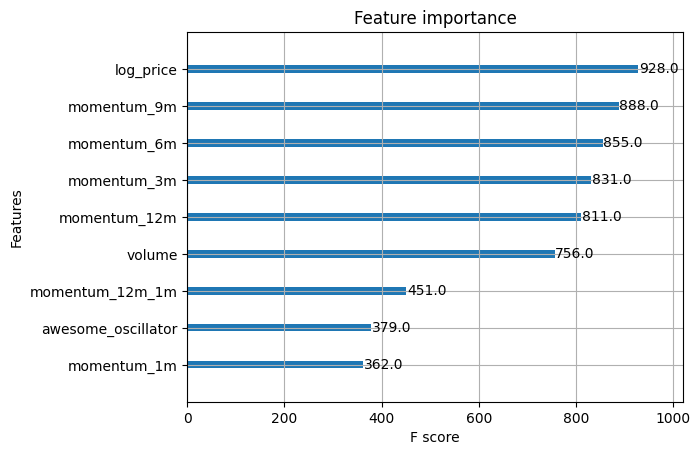

In [35]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

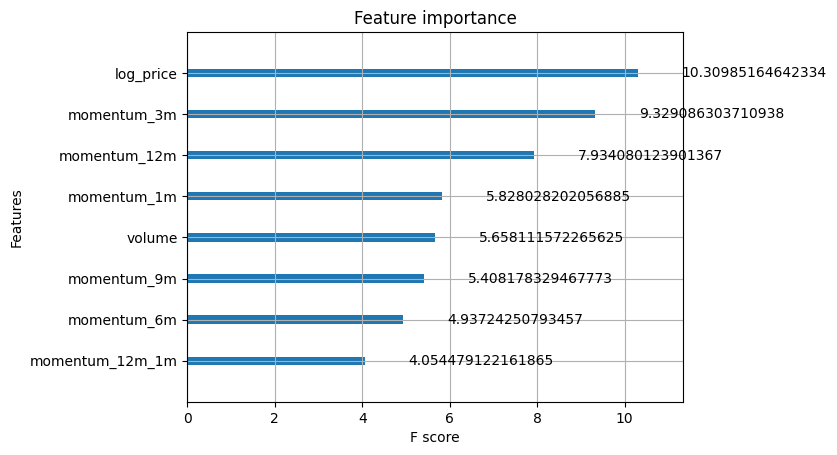

In [12]:
xgb.plot_importance(model, importance_type='gain')
plt.show()


In [ ]:
import numpy as np
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Global importance plot
shap.summary_plot(shap_values, X)

# Individual prediction explanation
shap.waterfall_plot(shap_values[0])


In [20]:
con.sql("select * from eps_history a where a.act_symbol = 'AAPL' order by a.period_end_date desc")

┌────────────┬─────────────────┬───────────────┬───────────────┐
│ act_symbol │ period_end_date │   reported    │   estimate    │
│  varchar   │      date       │ decimal(16,2) │ decimal(16,2) │
├────────────┼─────────────────┼───────────────┼───────────────┤
│ AAPL       │ 2024-09-30      │          1.64 │          1.49 │
│ AAPL       │ 2024-06-30      │          1.40 │          1.34 │
│ AAPL       │ 2024-03-31      │          1.53 │          1.51 │
│ AAPL       │ 2023-12-31      │          2.18 │          2.09 │
│ AAPL       │ 2023-09-30      │          1.46 │          1.39 │
│ AAPL       │ 2023-06-30      │          1.52 │          1.44 │
│ AAPL       │ 2023-03-31      │          1.88 │          1.93 │
│ AAPL       │ 2022-12-31      │          1.88 │          1.93 │
│ AAPL       │ 2022-09-30      │          1.29 │          1.26 │
│ AAPL       │ 2022-06-30      │          1.20 │          1.14 │
│  ·         │     ·           │            ·  │            ·  │
│  ·         │     ·     

In [68]:
con.sql("""
with cte as (
    select 
    *,
    LEAD(close, 21) OVER (PARTITION BY act_symbol ORDER BY date ASC) AS close_1m_fwd,
    (close_1m_fwd - close) / close AS return_1m_fwd,
    from pricing a 
)
select 
--count(*) 
*
from cte 
where return_1m_fwd > 1 and return_1m_fwd < 2 --'inf'
--and act_symbol = 'AAPL' --order by a.period_end_date desc
""")


┌────────────┬────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬────────────┬────────────────────┬────────────────────┐
│    date    │ act_symbol │        open        │        high        │        low         │       close        │   volume   │    close_1m_fwd    │   return_1m_fwd    │
│    date    │  varchar   │       double       │       double       │       double       │       double       │   double   │       double       │       double       │
├────────────┼────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼────────────┼────────────────────┼────────────────────┤
│ 2011-05-31 │ SPCB       │                8.0 │                8.0 │                8.0 │                8.0 │      1.865 │               18.0 │               1.25 │
│ 2011-09-29 │ SPCB       │               12.0 │               12.0 │               12.0 │               12.0 │        2.5 │               30.0 │                1.5 

In [71]:
con.sql("select * from split_adj a where a.act_symbol = 'SPCB'-- order by a.date desc")

┌────────────┬────────────┬──────────────┬────────────┬────────────────┐
│ act_symbol │  adj_date  │ end_adj_date │ adj_factor │ cum_adj_factor │
│  varchar   │    date    │     date     │   double   │     double     │
├────────────┼────────────┼──────────────┼────────────┼────────────────┤
│ SPCB       │ 2000-01-01 │ 2022-11-22   │       NULL │          200.0 │
│ SPCB       │ 2022-11-23 │ 2024-08-21   │       10.0 │           20.0 │
│ SPCB       │ 2024-08-22 │ NULL         │       20.0 │            1.0 │
└────────────┴────────────┴──────────────┴────────────┴────────────────┘

In [80]:
con.sql("select * from ohlcv a where a.act_symbol = 'SPCB' and date > '2022-11-01' and date < '2022-12-01' order by a.date ")

┌────────────┬────────────┬──────────────┬──────────────┬──────────────┬──────────────┬────────┐
│    date    │ act_symbol │     open     │     high     │     low      │    close     │ volume │
│    date    │  varchar   │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │ decimal(7,2) │ int64  │
├────────────┼────────────┼──────────────┼──────────────┼──────────────┼──────────────┼────────┤
│ 2022-11-02 │ SPCB       │         0.24 │         0.25 │         0.22 │         0.23 │ 390043 │
│ 2022-11-03 │ SPCB       │         0.24 │         0.24 │         0.22 │         0.23 │ 296507 │
│ 2022-11-04 │ SPCB       │         0.23 │         0.23 │         0.22 │         0.23 │ 208242 │
│ 2022-11-07 │ SPCB       │         0.24 │         0.24 │         0.22 │         0.23 │ 287721 │
│ 2022-11-08 │ SPCB       │         0.23 │         0.23 │         0.22 │         0.22 │ 129061 │
│ 2022-11-09 │ SPCB       │         0.23 │         0.23 │         0.21 │         0.21 │ 310340 │
│ 2022-11-10 │ SPCB       │   

In [98]:
con.sql("select * from pricing a where a.act_symbol = 'SPCB' and date > '2013-01-01 ' and date < '2013-02-01' order by a.date ")

┌────────────┬────────────┬────────────────────┬────────────────────┬────────────────────┬────────────────────┬──────────┐
│    date    │ act_symbol │        open        │        high        │        low         │       close        │  volume  │
│    date    │  varchar   │       double       │       double       │       double       │       double       │  double  │
├────────────┼────────────┼────────────────────┼────────────────────┼────────────────────┼────────────────────┼──────────┤
│ 2013-01-02 │ SPCB       │ 28.000000000000004 │ 28.000000000000004 │ 28.000000000000004 │ 28.000000000000004 │    111.4 │
│ 2013-01-03 │ SPCB       │               12.0 │               26.0 │               12.0 │               26.0 │    70.24 │
│ 2013-01-04 │ SPCB       │ 28.000000000000004 │ 28.000000000000004 │ 28.000000000000004 │ 28.000000000000004 │    3.725 │
│ 2013-01-18 │ SPCB       │               16.0 │               26.0 │               16.0 │               26.0 │  103.575 │
│ 2013-01-21 │ S

In [106]:
con.sql("""
WITH data_with_gaps AS (
    SELECT 
        *,
        -- Identify the previous non-NULL value and its date
        MAX(CASE WHEN close IS NOT NULL THEN close ELSE NULL END) OVER (
            PARTITION BY act_symbol
            ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS prev_value,
        MAX(CASE WHEN close IS NOT NULL THEN date ELSE NULL END) OVER (
            PARTITION BY act_symbol
            ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS prev_date,

        -- Identify the next non-NULL value and its date
        MIN(CASE WHEN close IS NOT NULL THEN close ELSE NULL END) OVER (
            PARTITION BY act_symbol
            ORDER BY date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
        ) AS next_value,
        MIN(CASE WHEN close IS NOT NULL THEN date ELSE NULL END) OVER (
            PARTITION BY act_symbol
            ORDER BY date ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING
        ) AS next_date
    FROM pricing
),
interpolated_data AS (
    SELECT 
        date,
        act_symbol,
        close,
        -- Perform linear interpolation for rows with NULL close values
        CASE
            WHEN close IS NULL AND prev_value IS NOT NULL AND next_value IS NOT NULL THEN
                prev_value + 
                (next_value - prev_value) * 
                DATE_DIFF('day', prev_date, date) /
                NULLIF(DATE_DIFF('day', prev_date, next_date), 0)
            ELSE close
        END AS interpolated_close
    FROM data_with_gaps
)
SELECT date, act_symbol, interpolated_close AS close
FROM interpolated_data
where act_symbol = 'SPCB' and date > '2013-01-01 ' and date < '2013-02-01' 
order by date;
""")

┌────────────┬────────────┬────────────────────┐
│    date    │ act_symbol │       close        │
│    date    │  varchar   │       double       │
├────────────┼────────────┼────────────────────┤
│ 2013-01-02 │ SPCB       │ 28.000000000000004 │
│ 2013-01-03 │ SPCB       │               26.0 │
│ 2013-01-04 │ SPCB       │ 28.000000000000004 │
│ 2013-01-18 │ SPCB       │               26.0 │
│ 2013-01-21 │ SPCB       │               26.0 │
│ 2013-01-22 │ SPCB       │               26.0 │
│ 2013-01-23 │ SPCB       │ 14.000000000000002 │
│ 2013-01-24 │ SPCB       │ 14.000000000000002 │
│ 2013-01-25 │ SPCB       │               20.0 │
│ 2013-01-28 │ SPCB       │               20.0 │
│ 2013-01-29 │ SPCB       │               22.0 │
│ 2013-01-31 │ SPCB       │               22.0 │
├────────────┴────────────┴────────────────────┤
│ 12 rows                            3 columns │
└──────────────────────────────────────────────┘

# Close Database Connection

In [122]:
con.close()